# Mask R-CNN - Analisis modelo entrenamiento

AI-Bootcamp DEMO

In [2]:
import os
import sys
import random
import math
import re
import time
import cv2
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from Mask import utils
from Mask import visualize
from coco import CocoConfig
from Mask.visualize import display_images
import Mask.model as modellib
from Mask.model import log

%matplotlib inline

C:\Users\algonzalez\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
config = CocoConfig()
config.display()

model = modellib.MaskRCNN(mode="inference", model_dir="./models/", config=config)
model.load_weights(filepath="./models/mask_rcnn_moles_0090.h5", by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

## Configuraciones iniciales

In [4]:
DEVICE = "/cpu:0"  # /gpu:0

# values: 'inference' | 'training'
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Ejecucion de la deteccion

In [6]:
img = cv2.imread("./static/img/1.jpg", cv2.IMREAD_COLOR)
rgb_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
h, w, channels = img.shape

class_names = ["BG", "malignant", "benign"]
r = model.detect([rgb_img])[0]

# Display results
visualize.display_instances(rgb_img, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

(array([[[216, 178, 159],
         [215, 177, 158],
         [214, 176, 155],
         ...,
         [213, 168, 145],
         [213, 168, 145],
         [213, 168, 145]],
 
        [[216, 178, 159],
         [216, 178, 159],
         [215, 177, 158],
         ...,
         [213, 168, 145],
         [213, 168, 145],
         [212, 167, 144]],
 
        [[217, 178, 161],
         [217, 179, 160],
         [217, 179, 160],
         ...,
         [212, 167, 144],
         [212, 167, 144],
         [211, 166, 143]],
 
        ...,
 
        [[214, 169, 150],
         [212, 169, 150],
         [213, 170, 151],
         ...,
         [199, 148, 119],
         [199, 148, 119],
         [198, 147, 116]],
 
        [[213, 168, 149],
         [213, 168, 149],
         [211, 168, 149],
         ...,
         [199, 148, 119],
         [199, 148, 119],
         [198, 147, 116]],
 
        [[212, 167, 148],
         [212, 167, 148],
         [210, 167, 148],
         ...,
         [199, 148, 119],
  

## Paso a paso para la detecccion

## Fase 1: Region Proposal Network

La Red de Propuestas de Región (RPN) ejecuta un clasificador binario en una gran cantidad de regiones(anchors) sobre la imagen y devuelve puntuaciones de objetos / no objetos. Los anchors con alta puntuación de objetividad (anchors positivos) se pasan a la etapa dos para ser clasificados.

A menudo, incluso los anchors positivos no cubren los objetos completamente. Por lo tanto, el RPN también realiza un refinamiento (un delta en ubicación y tamaño) que se aplicará a los anchors para cambiarlo y redimensionarlo un poco a los límites correctos del objeto.

### 1.a RPN Targets

Los targets RPN son los valores de entrenamiento para el RPN. Para generar los targets, comenzamos con una cuadrícula de anchors que cubren la imagen completa en diferentes escalas, y luego calculamos la IoU de los anchors con el objeto de verdad fundamental. Los anchors positivos son aquellos que tienen una IoU> = 0.7 con cualquier objeto de verdad básica, y los anchors negativos son aquellos que no cubren ningún objeto por más de 0.3 IoU. Los anchors intermedios (es decir, que cubren un objeto por IoU> = 0.3 pero <0.7) se consideran neutrales y se excluyen del entrenamiento.

Para entrenar al regresor RPN, también calculamos el shift y el cambio de tamaño necesarios para que el anchor cubra completamente el objeto del Ground Truth.

In [7]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
  rgb_img.shape, model.anchors,  r['class_ids'], r['rois'], config)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


positive_anchors         shape: (1, 4)                min: -192.00000  max:  320.00000  float64
negative_anchors         shape: (255, 4)              min: -149.01934  max:  213.01934  float64
neutral anchors          shape: (3836, 4)             min: -362.03867  max:  426.03867  float64
refined_anchors          shape: (1, 4)                min:  203.00000  max:  361.00000  float32


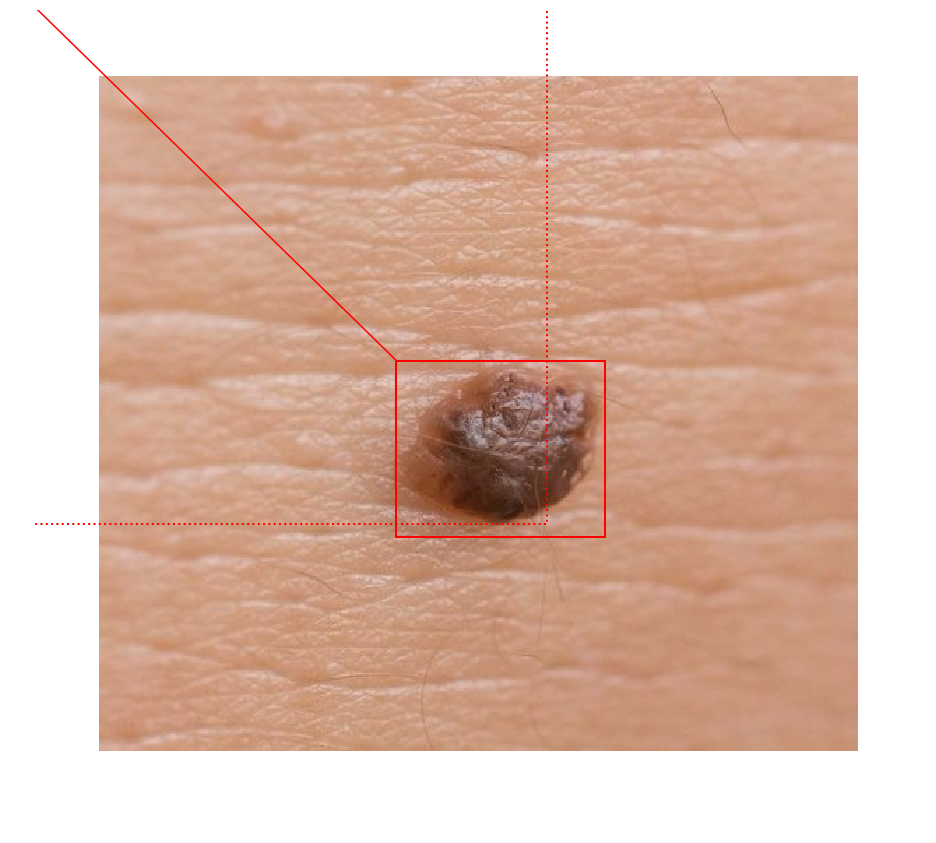

In [8]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(rgb_img, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Prediccciones

Aquí ejecutamos el gráfico RPN y mostramos sus predicciones.

In [9]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([rgb_img], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 4092, 2)          min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 4092, 4)          min:   -2.85070  max:    3.34676  float32
refined_anchors          shape: (1, 4092, 4)          min: -1915.63855  max: 1915.99963  float32
refined_anchors_clipped  shape: (1, 4092, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (561,)                min:    0.00000  max: 3205.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


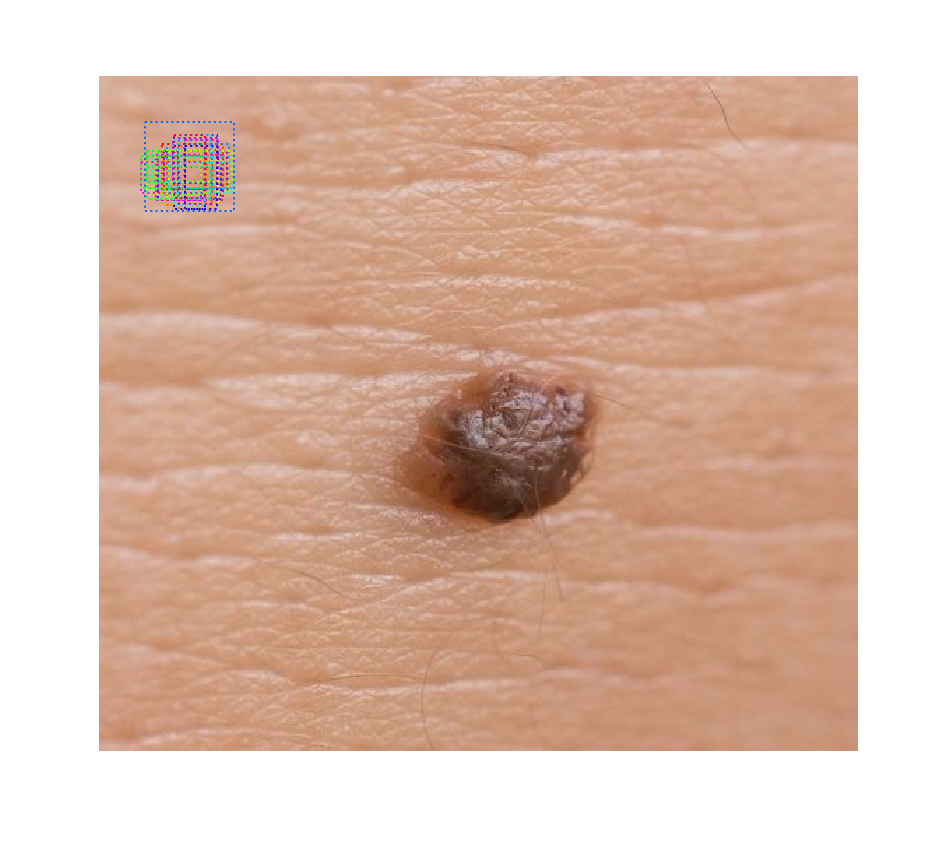

In [10]:
# Show top anchors by score (before refinement)
limit = 50
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(rgb_img, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

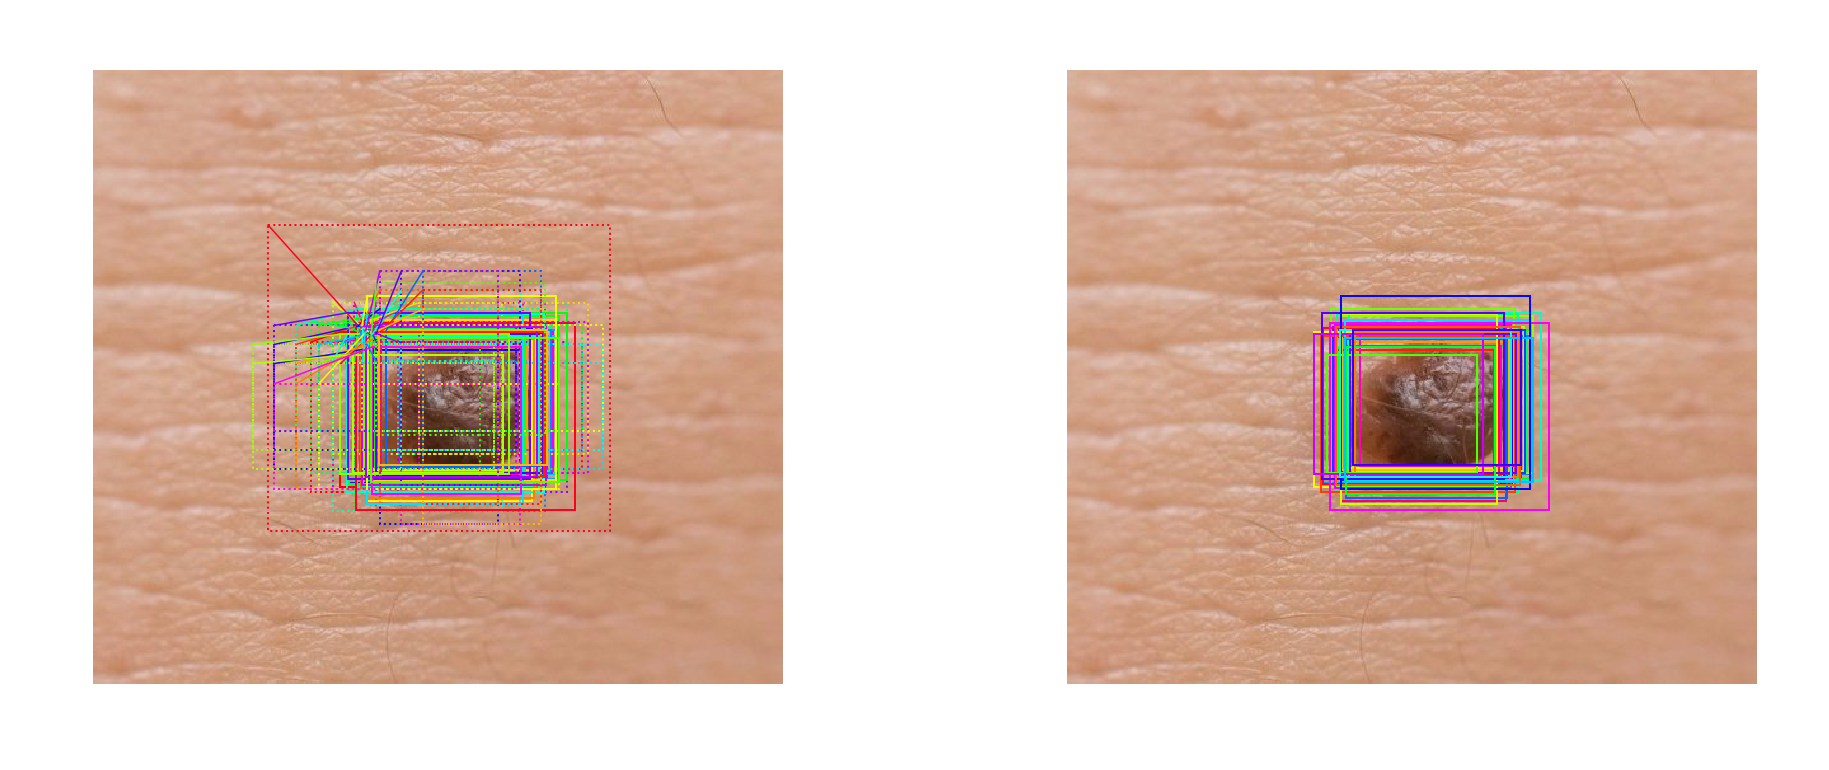

In [11]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], rgb_img.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], rgb_img.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], rgb_img.shape[:2])
visualize.draw_boxes(rgb_img, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(rgb_img, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

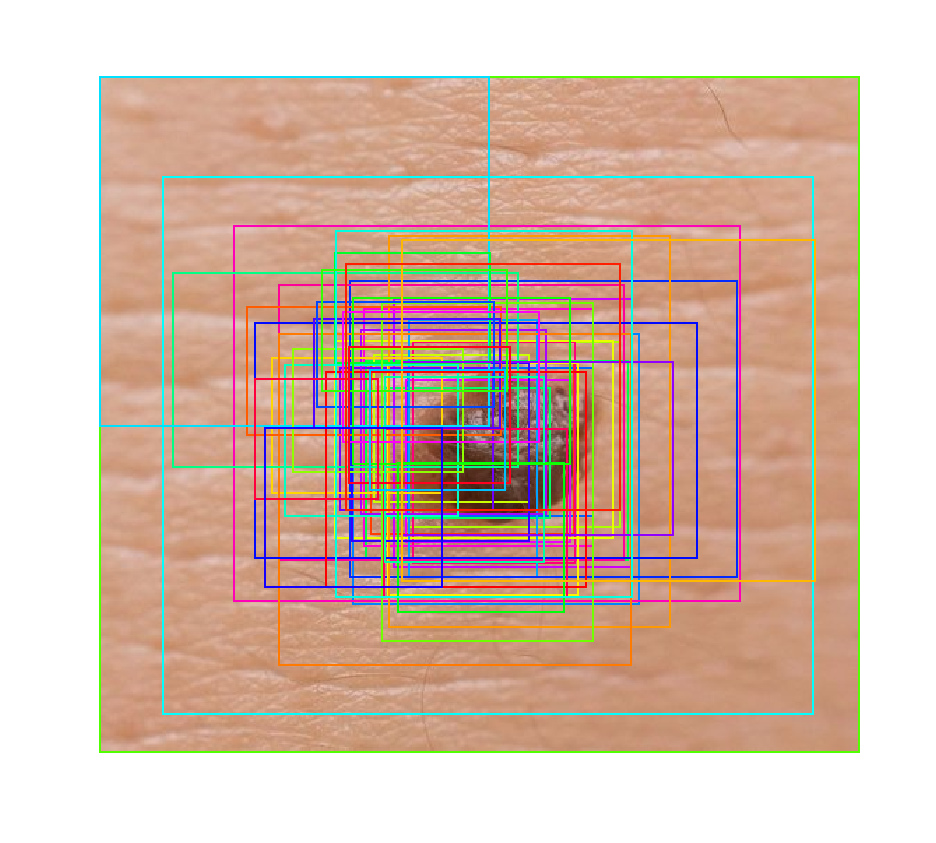

In [12]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(rgb_img, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

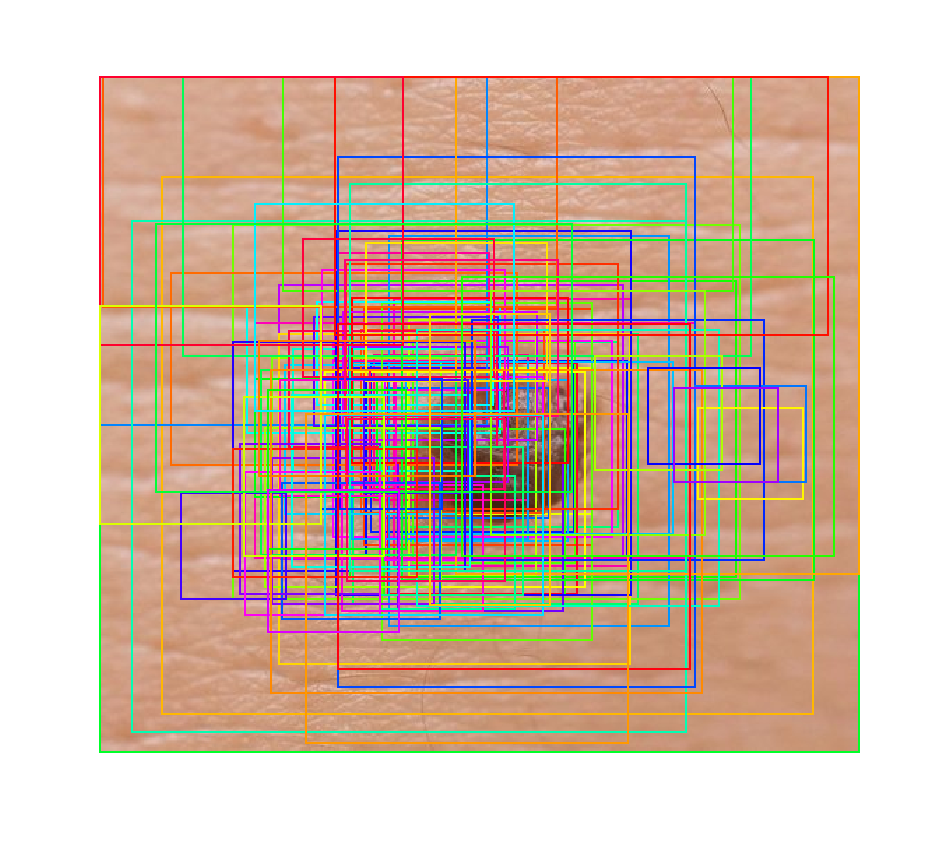

In [13]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 100
# Convert back to image coordinates for display
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(rgb_img, refined_boxes=proposals, ax=get_ax())

### 2.a Proposal Classification

Ejecuta los encabezados de los clasificadores en las propuestas(Proposals) para generar posibilidades de clase y regresiones de cuadro delimitador(Bounding Box Regressions).

## Fase 2: Clasificación Proposal

Esta etapa toma las propuestas regionales(Regional Proposals) del RPN y las clasifica.

In [14]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([rgb_img], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -5.05658  max:    5.51744  float32
masks                    shape: (1, 3, 28, 28, 3)     min:    0.00013  max:    1.00000  float32
detections               shape: (1, 3, 6)             min:    0.00000  max:    2.00000  float32


1 detections: ['benign']


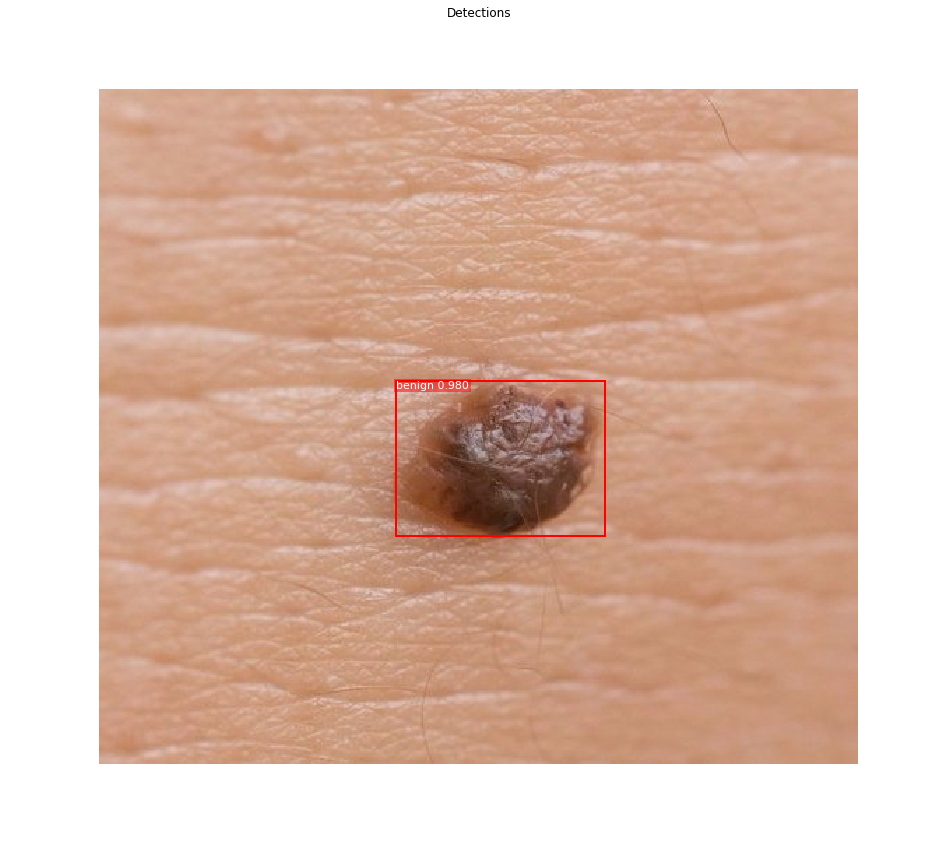

In [15]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    rgb_img, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], rgb_img.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Aquí profundizamos en el proceso de procesamiento de las detecciones.

In [16]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

561 Valid proposals out of 1000
24 Positive ROIs
[('BG', 976), ('benign', 24)]


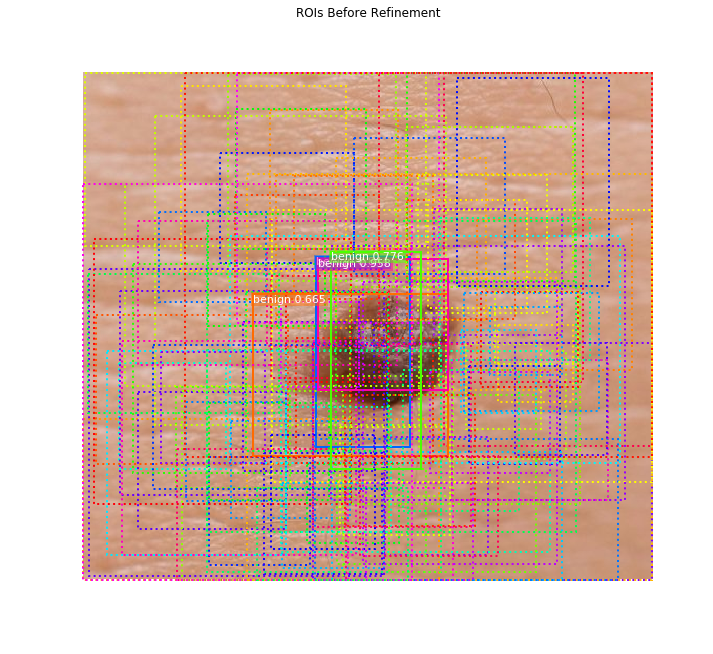

In [17]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(rgb_img, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement")

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.98424  max:    3.10162  float32
refined_proposals        shape: (1000, 4)             min: -157.00000  max:  567.00000  int32


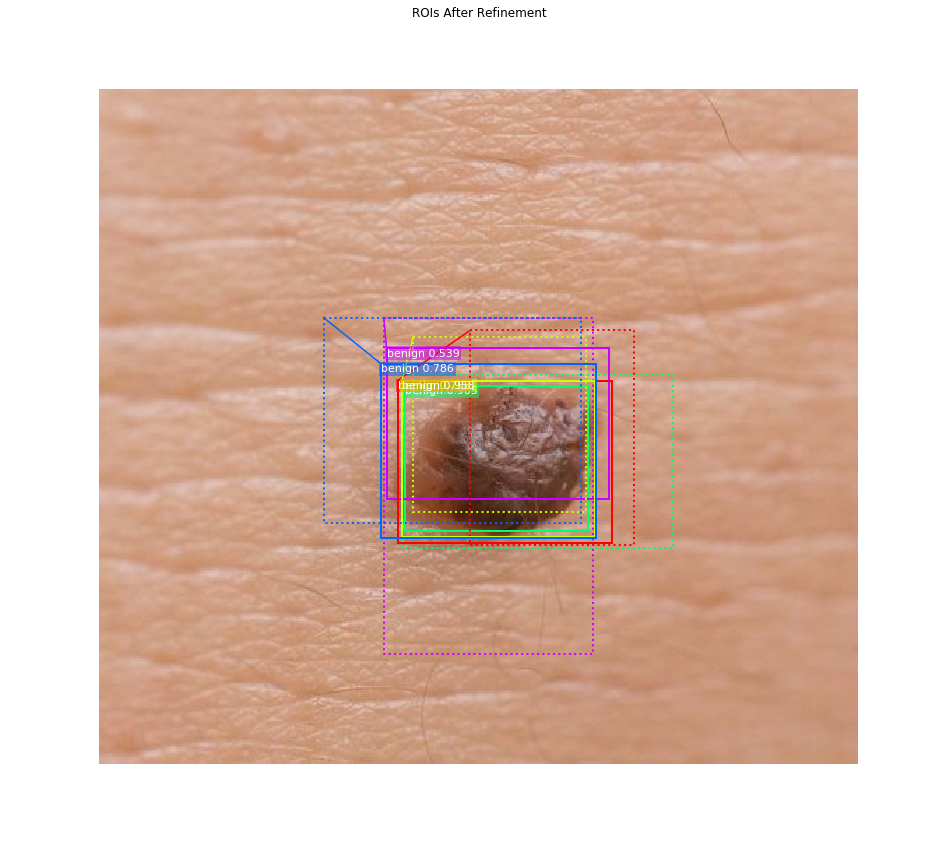

In [18]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
#ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(rgb_img, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [19]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 24 detections:
[  0   1   2   3   4   5   6   7   8   9  10  11  13  15  18  20  32  35
  36  40  99 100 160 216]


In [20]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 20:
[  0   1   2   3   4   5   6   7   8   9  11  13  18  20  36  40  99 100
 160 216]


#### Per-Class Non-Max Suppression
   En esta fase se agruparan los bounding boxes que contienen el mismo objeto, y se conservara el que mayor confianza y se descartara el resto, por lo tanto nuestra pantalla no se colapsara de recuadros de predicciones sino que tenderemos a solo mostrar el que mayor acierto tenga

In [21]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

benign                : [  0   1   2   3   4   5   6   7   8   9  11  13  18  20  36  40  99 100
 160 216] -> [0]

Kept after per-class NMS: 1
[0]


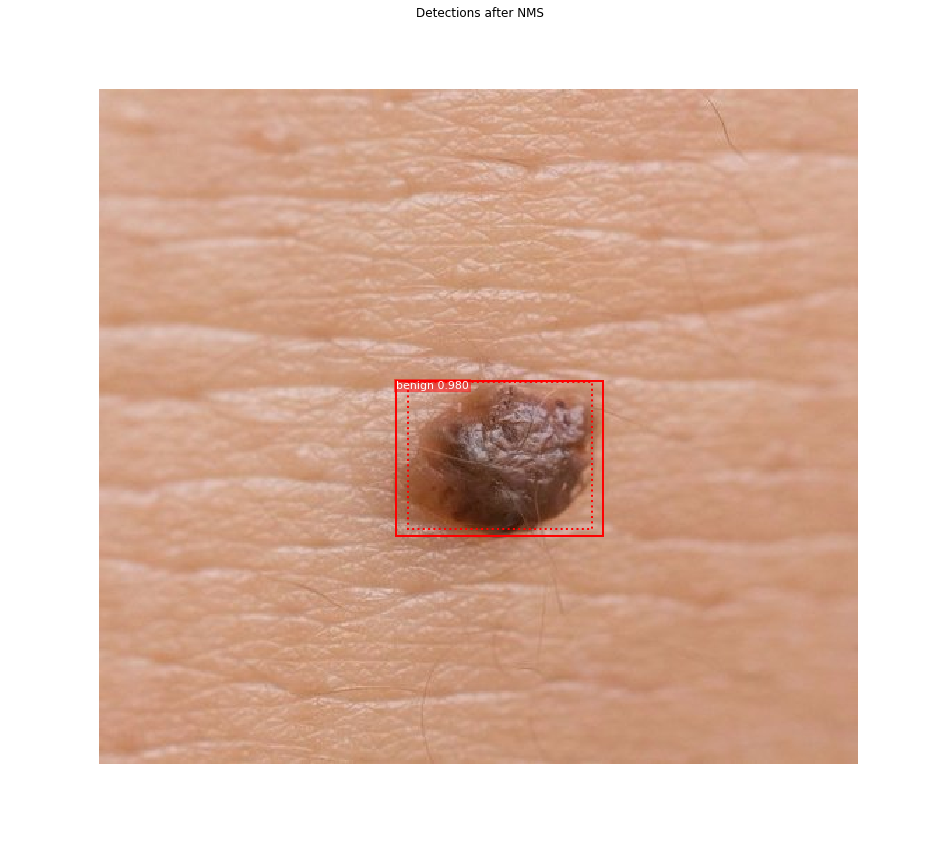

In [22]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    rgb_img, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generar Masks

Esta etapa toma las detecciones (refined bounding boxes and class IDs) de la capa anterior y ejecuta el encabezado de la máscara para generar máscaras de segmentación para cada instancia.

### 3.a Mask Targets

Estos son los targets de entrenamiento para la rama de la máscara.

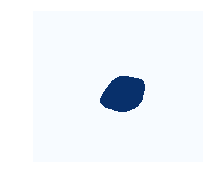

In [23]:
display_images(np.transpose(r['masks'], [2, 0, 1]), cmap="Blues")

### 3.b  Masks predecidas

In [24]:
# Get predictions of mask head
mrcnn = model.run_graph([rgb_img], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

detections               shape: (1, 3, 6)             min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 3, 28, 28, 3)     min:    0.00013  max:    1.00000  float32
1 detections: ['benign']


In [25]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], rgb_img.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], rgb_img.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (1, 28, 28)           min:    0.00013  max:    1.00000  float32
det_masks                shape: (1, 483, 543)         min:    0.00000  max:    1.00000  bool


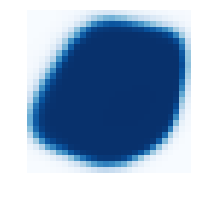

In [26]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

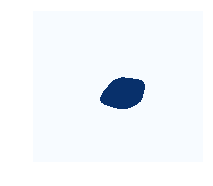

In [27]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")